# Fitting discrete distributions with weights

Here, I outline the strategy for fitting the underlying distribution from discretized data points that have weights.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from statsmodels.stats.weightstats import DescrStatsW
import statsmodels.api as sm
import numpy as np
from sklearn.datasets import make_spd_matrix
from sklearn.decomposition import PCA
import itertools
import time

In [13]:
from statsmodels.stats.moment_helpers import cov2corr


## Explore dirilict distribution

In [74]:
mu = np.array(np.random.normal(1, .4, size=2000))
cov = make_spd_matrix(2000)/10
p=0.1
num_cells = 10000

In [75]:
mvn = np.random.multivariate_normal(mu, cov, size=num_cells)
#ground_truth_counts = np.round(mvn)
ground_truth_counts = np.round(np.exp(mvn))
observed = np.random.binomial(n=ground_truth_counts.astype(int), p=p)

In [77]:
proportions = ground_truth_counts / np.tile(ground_truth_counts.sum(axis=1).reshape(-1, 1), (1, 2000))

In [78]:
total_sums = ground_truth_counts.sum(axis=1)

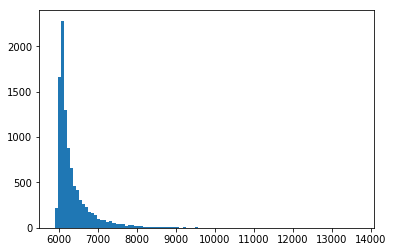

In [79]:
plt.hist(total_sums, bins=100);

In [80]:
proportions

array([[0.00033167, 0.00066335, 0.00082919, ..., 0.00099502, 0.00066335,
        0.00033167],
       [0.00031581, 0.00094742, 0.00126322, ..., 0.00063161, 0.00047371,
        0.00031581],
       [0.00014881, 0.00104167, 0.00193452, ..., 0.00104167, 0.00059524,
        0.00029762],
       ...,
       [0.00045851, 0.00061134, 0.00168119, ..., 0.00076418, 0.00061134,
        0.00045851],
       [0.0007593 , 0.00060744, 0.00015186, ..., 0.00030372, 0.00045558,
        0.00091116],
       [0.00013414, 0.00093897, 0.00160966, ..., 0.0017438 , 0.00053655,
        0.00026828]])

In [ ]:
start = time.time()
calculated_covariance = np.cov(ground_truth_counts.T, bias=1)
print(time.time() - start)

## Generate mixed data

In [170]:
p = 0.1
control_mu = 0.4
control_sigma = 0.4
case_mu = 0.7
case_sigma = 4
N = 10000

control_data = stats.lognorm.rvs(s=control_sigma, scale=np.exp(control_mu), size=int(N/2))
case_data = stats.lognorm.rvs(s=control_sigma, scale=np.exp(case_mu), size=int(N/2))

y = np.round(np.concatenate([control_data, case_data]))
x = np.concatenate([np.zeros(int(N/2)), np.ones(int(N/2))])
observed = np.random.binomial(n=y.astype(int), p=p)
#x = sm.add_constant(x)

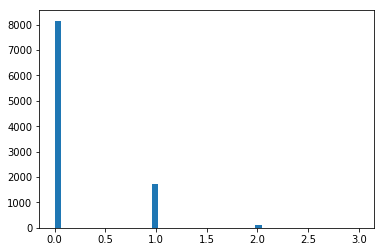

In [158]:
plt.hist(observed, bins=50);

### Initialization

In [159]:
NUM_ITER = 200
MAX_LATENT = 30

In [160]:
initial_mu = 2
initial_sigma = 2

### Lognormal discretized CDF

In [161]:
def rv_pmf(x, mu, sigma):
    """ PDF/PMF of the random variable under use. """
    
    return stats.lognorm.cdf(0.5, s=sigma, loc=0, scale=np.exp(mu))*(x==0) + \
        (stats.lognorm.cdf(x+0.5, s=sigma, loc=0, scale=np.exp(mu)) - stats.lognorm.cdf(x-0.5, s=sigma, loc=0, scale=np.exp(mu)))*(x!=0)

### Create base dataframe

In [162]:
data = pd.DataFrame()
data['observed'] = observed
data['case'] = x
data = data.groupby(['observed', 'case']).size().reset_index(name='count')
data['observed_weight'] = data['count'] / len(observed)
# data.set_index('observed', inplace=True)

In [166]:
base_dataframe = pd.concat(
    [pd.DataFrame(
        np.concatenate(
            [np.ones(MAX_LATENT-i).reshape(-1, 1)*i, 
            np.arange(i, MAX_LATENT).reshape(-1,1)], axis=1), 
        columns=['observed', 'latent']) for i in range(MAX_LATENT)])
base_dataframe.set_index('observed', inplace=True)

In [167]:
base_dataframe.head(5)

,latent
observed,
0.0,0.0
0.0,1.0
0.0,2.0
0.0,3.0
0.0,4.0


In [165]:
binom_table = np.zeros(shape=(MAX_LATENT, MAX_LATENT))
    
for i in range(MAX_LATENT):
    for z in range(i, MAX_LATENT):
        binom_table[i, z] = stats.binom.pmf(i, z, p)

TypeError: only integer scalar arrays can be converted to a scalar index

In [150]:
base_dataframe['dropout_weight'] = np.concatenate([binom_table[i, i:].reshape(-1, 1) for i in range(MAX_LATENT)])

In [151]:
probs = rv_pmf(np.arange(MAX_LATENT), mu=initial_mu, sigma=initial_sigma)

In [152]:
base_dataframe['latent_lognorm_weight'] = np.concatenate([probs[i:].reshape(-1, 1) for i in range(MAX_LATENT)])

In [153]:
base_dataframe.shape

(465, 3)

In [154]:
x

29

In [155]:
data.head(5)

,observed,case,count,observed_weight
0,0,29,8228,0.8228
1,1,29,1664,0.1664
2,2,29,101,0.0101
3,3,29,7,0.0007


In [81]:
base_dataframe.tail(2)

,latent,dropout_weight,latent_lognorm_weight
observed,,,
28.0,29.0,2.610000e-27,0.005446
29.0,29.0,1.000000e-29,0.005446


In [80]:
rv_pmf(199, mu=initial_mu, sigma=initial_sigma)

0.0002583701093287205

In [62]:
base_dataframe.shape

(20100, 2)

In [61]:
probs.shape

(200,)

In [6]:
data = stats.norm.rvs(loc=5, scale=4, size=2000)

In [11]:
np.sqrt(data.var())*np.sqrt(2)/np.sqrt(np.pi)

3.1541579598472578

In [12]:
np.absolute(data - data.mean()).mean()

3.1617039435274394

In [5]:
data.mean()

5.019118202198376

In [130]:
print(runtime)

0.0024080276489257812


In [42]:
runtime*200

32.16118812561035

In [112]:
s.shape

(500,)

In [40]:
temp = stats.lognorm.cdf(4, s=s, loc=0, scale=scale)

/anaconda3/envs/scvi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1735: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


In [96]:
probs[:5]

array([0.        , 0.12098536, 0.08056299, 0.06006905, 0.04757445])

In [ ]:
stats.multivariate_normal()

In [50]:
observed_counts

0    8287
1    1585
2     122
3       6
dtype: int64

In [ ]:
observed_y

In [47]:
probs = stats.lognorm.pdf(observed_y, s=initial_sigma, scale=np.exp(initial_mu))

In [48]:
probs

array([0.12098536, 0.        , 0.        , ..., 0.12098536, 0.        ,
       0.        ])

In [22]:
x = sm.add_constant(x)

In [23]:
#model = sm.WLS(y, x, np.concatenate([np.ones(N)*1/control_sigma**2, np.ones(N)*1/case_sigma**2])).fit()
model = sm.OLS(y, x).fit()

In [24]:
point_var = (y - model.predict(x))**2

In [25]:
var_model = sm.OLS(point_var, x).fit()

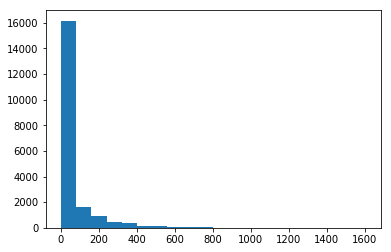

In [26]:
plt.hist(point_var, bins=20);

In [27]:
pred_means = model.predict(x)

In [28]:
pred_vars = np.sqrt(var_model.predict(x))

In [29]:
start = time.time()
probs = stats.norm.pdf(y, loc=pred_means, scale=pred_vars)
print(time.time()-start)

0.0029358863830566406
